# Support Vector Classifier (SVC) Model Development with BayesSearchCV Optimization

## Import Libraries

In [1]:
# records and calculations
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# core ML
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

#  BayesSearchCV optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

# Persistence
import joblib
import pickle

# avoid minor warnings
import warnings
warnings.filterwarnings('ignore')

# read file path
from pathlib import Path

## Load Dataset and Saved Artifacts

In [2]:
""" File and Artifacts Directories """

# dataset path
file = Path(r"../data/CleanedLoanData.csv")

# artifacts path
artifacts_dir = Path(r"../artifacts/feature-selection")

# model performance path
model_performance_dir = Path(r"../artifacts/model-performance")

# models path
model_dir = Path(r"../artifacts/models")


In [3]:
# laod dataset
df = pd.read_csv(file)

In [4]:
# feature-target separation
x = df.drop(columns=['LoanStatus'])
y = df['LoanStatus']

In [5]:
# load artifacts
x_train_scale = joblib.load(artifacts_dir / "x_train_scaler.pkl")
x_test_scale = joblib.load(artifacts_dir / "x_test_scaler.pkl")
y_train = joblib.load(artifacts_dir / "y_train.pkl")
y_test = joblib.load(artifacts_dir / "y_test.pkl")
cv = joblib.load(artifacts_dir / "cv.pkl")

# configure socring metrics
scoring_metrics = 'roc_auc'

# standardize features
svc_scaler = StandardScaler()

In [6]:
# load performance metrics
cross_val_df = pd.read_csv(model_performance_dir / "a_CrossValidationScore.csv")                # cross-validation scores
model_perf_df = pd.read_csv(model_performance_dir / "a_ModelsPerformance.csv")                  # all models performance
model_score_df = pd.read_csv(model_performance_dir / "a_ModelsScores.csv")                      # all models ranking
overfit_df = pd.read_csv(model_performance_dir / "a_OverfittingAnalysis.csv")                   # all models overfitting analysis

## Model Training with Hyperparameter Optimization

In [7]:
# hyperparameter tuning space
svc_param_space = {
    'C': Real(0.1, 100, prior='log-uniform'),
    'gamma': Real(0.001, 1, prior='log-uniform'),
    'kernel': Categorical(['rbf', 'linear']),
    'class_weight': Categorical(['balanced'])
}

In [8]:
# initialize base model
svc = SVC(probability=True, random_state=42)

# BayesSearch optimization
svc_bayes = BayesSearchCV(
    svc,
    svc_param_space,
    cv=cv,
    scoring=scoring_metrics,
    n_iter = 20,
    n_jobs=-1,
    random_state=42
)

In [9]:
# train model and identify best estimator
svc_bayes.fit(x_train_scale, y_train)

best_model = svc_bayes.best_estimator_

## Apply Model to Make Prediction and Get Probabilities

In [10]:
# make prediction on training and test set
train_pred = best_model.predict(x_train_scale)
test_pred = best_model.predict(x_test_scale)

In [11]:
# get predicted probabilities
train_proba = best_model.predict_proba(x_train_scale)[:, 1]
test_proba = best_model.predict_proba(x_test_scale)[:, 1]

## Evaluating Model Performance

In [12]:
# Training Metrics
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score

In [13]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score

### Performance Report for Training and Test Set

In [14]:
# classification report for train set
print("=== Performance on Training Set ===".center(55, '='))
train_report = classification_report(y_train, train_pred)
print(train_report)


============= Performance on Training Set =============
              precision    recall  f1-score   support

           0       0.51      0.84      0.63       153
           1       0.89      0.63      0.74       335

    accuracy                           0.70       488
   macro avg       0.70      0.73      0.69       488
weighted avg       0.77      0.70      0.71       488



In [15]:
# classification report for test set
print("=== Performance on Test Set ===".center(55, '='))
test_report = classification_report(y_test, test_pred)
print(test_report)

=============== Performance on Test Set ===============
              precision    recall  f1-score   support

           0       0.49      0.85      0.62        39
           1       0.89      0.58      0.71        84

    accuracy                           0.67       123
   macro avg       0.69      0.71      0.66       123
weighted avg       0.76      0.67      0.68       123



### Performance Metrics

In [16]:
# model status & gap generalization
model_status = 'Good' if test_acc > 0.85 else 'Fair' if test_acc > 0.75 else 'Needs Improvement'
generalization = 'Overfitting' if train_acc - test_acc > 0.05 else 'Best Fit'

# performance table
performance_df = pd.DataFrame({
    'Metric': [
        'AUC-ROC',
        'AUC-PR',
        'Precision',
        'Recall',
        'F1-Score',
        'Accuracy',
        'Generalization',
        'Model Status'
    ],
    'Training': [
        f"{train_auc_roc:.3f}",
        f"{train_auc_pr:.3f}",
        f"{train_precision:.3f}",
        f"{train_recall:.3f}",
        f"{train_f1:.3f}",
        f"{train_acc:.3f}",
        '-',
        '-'
    ],
    'Test': [
        f"{test_auc_roc:.3f}",
        f"{test_auc_pr:.3f}",
        f"{test_precision:.3f}",
        f"{test_recall:.3f}",
        f"{test_f1:.3f}",
        f"{test_acc:.3f}",
        '-',
        model_status
    ],
    'Gap/Generalization': [
        f"{abs(train_auc_roc - test_auc_roc):.3f}",
        f"{abs(train_auc_pr - test_auc_pr):.3f}",
        f"{abs(train_precision - test_precision):.3f}",
        f"{abs(train_recall - test_recall):.3f}",
        f"{abs(train_f1 - test_f1):.3f}",
        f"{abs(train_acc - test_acc):.3f}",
        generalization,
        '-'
    ]
})

In [17]:
# performance table
print("=== SVC Performance Metrics ===".center(52, '='))
performance_df

============= SVC Performance Metrics ==============


,Metric,Training,Test,Gap/Generalization
0,AUC-ROC,0.842,0.837,0.005
1,AUC-PR,0.891,0.879,0.013
2,Precision,0.895,0.891,0.004
3,Recall,0.633,0.583,0.050
4,F1-Score,0.741,0.705,0.036
5,Accuracy,0.697,0.667,0.030
6,Generalization,-,-,Best Fit
7,Model Status,-,Needs Improvement,-


In [18]:
print("=== Metrics Summary ===")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy Gap: {abs(train_acc - test_acc):.4f} ({generalization})")
print(f"Model Performance: {model_status}")

=== Metrics Summary ===
Training Accuracy: 0.6967
Test Accuracy: 0.6667
Accuracy Gap: 0.0301 (Best Fit)
Model Performance: Needs Improvement


## ROC-Curve

In [19]:
# roc curve for training and testing set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)

In [20]:
# calculate AUC for training and testing set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

**NOTE:** We can use training and test AUC-ROC (`roc_auc_score`) values to plot ROC curves

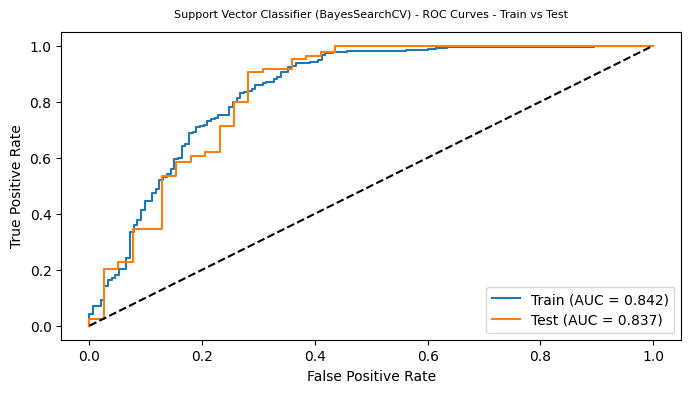

In [21]:
# figure size
plt.figure(figsize=(8, 4))

# ploting the curve
plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})')
plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Support Vector Classifier (BayesSearchCV) - ROC Curves - Train vs Test',  y=1.02, fontsize=8)
plt.legend()
plt.show()

## Confusion Matrix

In [22]:
# confusion matrix for training and test set
train_cnf = confusion_matrix(y_train, train_pred)
test_cnf = confusion_matrix(y_test, test_pred)

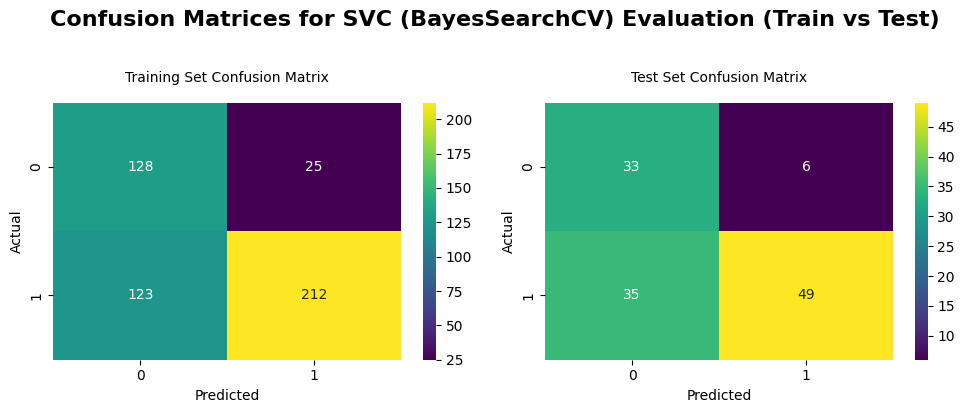

In [23]:
""" visualize confusion matrices """
# number of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

# confusion matrix for training set
ax = axes[0]
sns.heatmap(train_cnf, annot=True, fmt='d', cmap='viridis', ax=ax)

# set labels
ax.set_title("Training Set Confusion Matrix", fontsize=10, y=1.05)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")


# confusion matrix for test set
ax = axes[1]
sns.heatmap(test_cnf, annot=True, fmt='d', cmap='viridis', ax=ax)

# set labels
ax.set_title("Test Set Confusion Matrix", fontsize=10, y=1.05)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# ========== Layout ==========
plt.suptitle(f"Confusion Matrices for SVC (BayesSearchCV) Evaluation (Train vs Test)", y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Cross-Validation Scores

In [24]:
# calucate cross-validation scores
cv_scores = cross_val_score(best_model, x, y, cv=cv, scoring=scoring_metrics)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

In [25]:
# create dataframe
cv_df = pd.DataFrame({
    "Model": "SVC (BayesSearchCV)",
    "CV Mean": [cv_mean],
    "CV Std": [cv_std]
}).round(3)

In [26]:
cv_df

,Model,CV Mean,CV Std
0,SVC (BayesSearchCV),0.478,0.026


## Overfitting Analysis

In [27]:
# overfitting gap
overfitting_gap = abs(train_auc_roc - test_auc_roc)

# overfitting status
overfit_status = "High" if overfitting_gap > 0.6 else "Medium" if overfitting_gap > 0.4 else "Low"

# overfitting dictionary
overfit_model = pd.DataFrame({
    'Model': ['SVC (BayesSearchCV)'],
    'AUC-ROC Gap': [abs(train_auc_roc - test_auc_roc)],
    'AUC-PR Gap': [abs(train_auc_pr - test_auc_pr)],
    'Precision Gap': [abs(train_precision - test_precision)],
    'Recall Gap': [abs(train_recall - test_recall)],
    'F1-Score Gap': [abs(train_f1 - test_f1)],
    'Accuracy Gap': [abs(train_acc - test_acc)],
    'Overfitting Status': [overfit_status]
}).round(3)


In [28]:
print("=== Overfitting Analysis Table ===".center(130))
overfit_model

                                                === Overfitting Analysis Table ===                                                


,Model,AUC-ROC Gap,AUC-PR Gap,Precision Gap,Recall Gap,F1-Score Gap,Accuracy Gap,Overfitting Status
0,SVC (BayesSearchCV),0.005,0.013,0.004,0.05,0.036,0.03,Low


## Model Scoring

In [29]:
""" Composite score (higher is better) """

# Weighted combination: 30% CV mean, 15% low CV std, 15% test acc, 15% F1, 15% AUC, 10% low overfitting
composite_score = (0.3 * cv_mean) + (0.15 * (1-cv_std)) + (0.15 * test_acc) + \
                      (0.15 * test_f1) + (0.15 * test_auc) + (0.1 * (1-overfitting_gap))

In [30]:
model_score = pd.DataFrame({
    'Model': ['SVC (BayesSearchCV)'],
    'CV Mean': [cv_mean],
    'CV Std': [cv_std],
    'Test Accuracy': [test_acc],
    'Test F1-Score': [test_f1],
    'Test AUC': [test_auc_roc],
    'Overfitting Gap': [overfitting_gap],
    'Composite Score': [composite_score]
}).round(3)

In [31]:
print("=== Model Score Table ===".center(130))
model_score

                                                    === Model Score Table ===                                                     


,Model,CV Mean,CV Std,Test Accuracy,Test F1-Score,Test AUC,Overfitting Gap,Composite Score
0,SVC (BayesSearchCV),0.478,0.026,0.667,0.705,0.837,0.005,0.72


## Persist Model and Final Performance Table

In [32]:
# overall model performance
perf_df = pd.DataFrame({
    'Model': ['SVC (BayesSearchCV)'],
    'AUC-ROC': [test_auc_roc],
    'AUC-PR': [test_auc_pr],
    'Precision': [test_precision],
    'Recall': [test_recall],
    'F1-Score': [test_f1],
    'Accuracy': [test_acc],
    'CV AUC-ROC Mean': [cv_mean],
    'CV AUC-ROC Std': [cv_std],
    'AUC-ROC (Overfit) Gap': [overfitting_gap],
    'Composite Score': [composite_score],
    'Overfitting Status': [overfit_status],
    'Model Status': [model_status],
}).round(3)

In [33]:
perf_df

,Model,AUC-ROC,AUC-PR,Precision,Recall,F1-Score,Accuracy,CV AUC-ROC Mean,CV AUC-ROC Std,AUC-ROC (Overfit) Gap,Composite Score,Overfitting Status,Model Status
0,SVC (BayesSearchCV),0.837,0.879,0.891,0.583,0.705,0.667,0.478,0.026,0.005,0.72,Low,Needs Improvement


In [34]:
# save model performance
performance_path = model_performance_dir / "svcPerformance.csv"

# convert performance dataframe to csv
performance_df.to_csv(performance_path, index=False)

In [35]:
# concat with the existing dataframe
cv_df = pd.concat([cv_df, cross_val_df], ignore_index=True)

# update cross validation score by adding random forest regression
cv_path = model_performance_dir / "a_CrossValidationScore.csv"

cv_df.to_csv(cv_path, index=False)

In [36]:
# concat with the existing dataframe
overfit_model = pd.concat([overfit_model, overfit_df], ignore_index=True)

# overfitting analysis table
overfit_path = model_performance_dir / "a_OverfittingAnalysis.csv"

overfit_model.to_csv(overfit_path, index=False)

In [37]:
# concat with the existing dataframe
model_score = pd.concat([model_score, model_score_df], ignore_index=True)

# add to model scores table
model_score_path = model_performance_dir / "a_ModelsScores.csv"

model_score.to_csv(model_score_path, index=False)

In [38]:
# concat with the existing dataframe
perf_df = pd.concat([perf_df, model_perf_df], ignore_index=True)

# model comparison table
model_perf_path = model_performance_dir / "a_ModelsPerformance.csv"

perf_df.to_csv(model_perf_path, index=False)


In [39]:
#  saved model and test probabilities
joblib.dump(best_model, model_dir / "svc.pkl")
np.save(model_dir / "svc_testProba.npy", test_proba)